In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.initializers import glorot_uniform, RandomNormal
import random, os, pickle, copy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
savedir = os.path.join('./save/find_smallest_network_cifar5')

In [2]:
def map_to_range(arr):
    narr = np.zeros_like(arr, dtype=np.int64)
    vals = np.unique(arr)
    for i, v in enumerate(vals):
        mask = (arr == v)
        narr[mask] = i
    return narr

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
input_shape = (32, 32, 3)
num_classes = 5

y_test = y_test.astype(np.int64).squeeze()
y_train = y_train.astype(np.int64).squeeze()

# labels found to give roughly equal classification performance
set_1_test_mask = np.isin(y_test, np.array([0, 3, 4, 6, 7])).squeeze()
set_1_train_mask = np.isin(y_train, np.array([0, 3, 4, 6, 7])).squeeze()

set_2_test_mask = np.isin(y_test, np.array([1, 2, 5, 8, 9])).squeeze()
set_2_train_mask = np.isin(y_train, np.array([1, 2, 5, 8, 9])).squeeze()

set_1_train_labels = y_train[set_1_train_mask]
x_train_1 = x_train[set_1_train_mask]
set_1_test_labels = y_test[set_1_test_mask]
x_test_1 = x_test[set_1_test_mask]
set_2_train_labels = y_train[set_2_train_mask]
x_train_2 = x_train[set_2_train_mask]
set_2_test_labels = y_test[set_2_test_mask]
x_test_2 = x_test[set_2_test_mask]

y_train_1 = keras.utils.to_categorical(map_to_range(set_1_train_labels), num_classes)
y_train_2 = keras.utils.to_categorical(map_to_range(set_2_train_labels), num_classes)
y_test_1 = keras.utils.to_categorical(map_to_range(set_1_test_labels), num_classes)
y_test_2 = keras.utils.to_categorical(map_to_range(set_2_test_labels), num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
datagen1 = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )
datagen1.fit(x_train_1)

datagen2= ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )
datagen2.fit(x_train_2)

In [5]:
def set_up_model(lr=1e-3, nfilters=[2, 4, 8], ndense=128):
    keras.backend.clear_session()
    inputs = Input(shape=input_shape)
    x = Conv2D(nfilters[0], kernel_size=(7,7), strides=(1, 1), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(nfilters[1], kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(nfilters[2], kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Flatten()(x)
    x = Dense(ndense, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(lr=lr),
                  metrics=['accuracy'])
    return model

In [8]:
epochs = 100
batch_size = 128

n_dense = [32, 64, 128]
constant_filters = [2, 4, 8]
exp_filters = [1, 2, 3]
i = 0
for d in n_dense:
    for f in constant_filters:
        if i < 5:
            print('Skipping %d dense %d constant filters'%(d, f))
            i += 1
            continue
        
        model = set_up_model(nfilters=[f, f, f], ndense=d)
        history = model.fit_generator(datagen1.flow(x_train_1, y_train_1, batch_size=batch_size),
                                      epochs=epochs,
                                      verbose=2,
                                      validation_data=(x_test_1, y_test_1),
                                      )
        sp = os.path.join(savedir, 'history_%d_dense_%d_filters.pkl'%(d, f))
        print('Saving to :', sp)
        with open(sp, 'wb') as f:
            pickle.dump(history.history, f)

    for f in exp_filters:
        if i < 5:
            print('Skipping %d dense %d exp filters'%(d, f))
            i += 1
            continue
        model = set_up_model(nfilters=[2**(f), 2**(f+1), 2**(f+2)], ndense=d)
        history = model.fit_generator(datagen1.flow(x_train_1, y_train_1, batch_size=batch_size),
                                      epochs=epochs,
                                      verbose=2,
                                      validation_data=(x_test_1, y_test_1),
                                      )
        sp = os.path.join(savedir, 'history_%d_dense_exp_%d_filters.pkl'%(d, f))
        print('Saving to :', sp)
        with open(sp, 'wb') as f:
            pickle.dump(history.history, f)

Skipping 32 dense 2 constant filters
Skipping 32 dense 4 constant filters
Skipping 32 dense 8 constant filters
Skipping 32 dense 1 exp filters
Skipping 32 dense 2 exp filters
Epoch 1/100
 - 11s - loss: 1.4309 - acc: 0.3645 - val_loss: 1.2284 - val_acc: 0.5158
Epoch 2/100
 - 9s - loss: 1.2899 - acc: 0.4589 - val_loss: 1.1067 - val_acc: 0.5696
Epoch 3/100
 - 9s - loss: 1.2210 - acc: 0.4963 - val_loss: 1.0456 - val_acc: 0.5968
Epoch 4/100
 - 9s - loss: 1.1667 - acc: 0.5262 - val_loss: 0.9825 - val_acc: 0.6138
Epoch 5/100
 - 9s - loss: 1.1441 - acc: 0.5378 - val_loss: 0.9793 - val_acc: 0.6218
Epoch 6/100
 - 9s - loss: 1.1183 - acc: 0.5549 - val_loss: 0.9336 - val_acc: 0.6486
Epoch 7/100
 - 9s - loss: 1.0989 - acc: 0.5617 - val_loss: 0.8989 - val_acc: 0.6512
Epoch 8/100
 - 9s - loss: 1.0728 - acc: 0.5763 - val_loss: 0.9000 - val_acc: 0.6540
Epoch 9/100
 - 9s - loss: 1.0559 - acc: 0.5883 - val_loss: 0.8646 - val_acc: 0.6772
Epoch 10/100
 - 9s - loss: 1.0354 - acc: 0.5936 - val_loss: 0.8459 -

Epoch 96/100
 - 9s - loss: 0.7309 - acc: 0.7267 - val_loss: 0.5710 - val_acc: 0.7960
Epoch 97/100
 - 9s - loss: 0.7273 - acc: 0.7294 - val_loss: 0.5785 - val_acc: 0.7910
Epoch 98/100
 - 9s - loss: 0.7255 - acc: 0.7299 - val_loss: 0.5929 - val_acc: 0.7900
Epoch 99/100
 - 9s - loss: 0.7208 - acc: 0.7327 - val_loss: 0.6057 - val_acc: 0.7690
Epoch 100/100
 - 9s - loss: 0.7257 - acc: 0.7309 - val_loss: 0.5677 - val_acc: 0.7940
Saving to : ./save/find_smallest_network_cifar5\history_32_dense_exp_3_filters.pkl
Epoch 1/100
 - 9s - loss: 1.4869 - acc: 0.3410 - val_loss: 1.3267 - val_acc: 0.4440
Epoch 2/100
 - 9s - loss: 1.3467 - acc: 0.4314 - val_loss: 1.2849 - val_acc: 0.4500
Epoch 3/100
 - 9s - loss: 1.3212 - acc: 0.4404 - val_loss: 1.2577 - val_acc: 0.4732
Epoch 4/100
 - 9s - loss: 1.3008 - acc: 0.4493 - val_loss: 1.2366 - val_acc: 0.4754
Epoch 5/100
 - 9s - loss: 1.2854 - acc: 0.4634 - val_loss: 1.2213 - val_acc: 0.5102
Epoch 6/100
 - 9s - loss: 1.2732 - acc: 0.4739 - val_loss: 1.1951 - val

Epoch 92/100
 - 9s - loss: 1.0819 - acc: 0.5743 - val_loss: 0.9914 - val_acc: 0.6086
Epoch 93/100
 - 9s - loss: 1.0834 - acc: 0.5729 - val_loss: 1.0072 - val_acc: 0.6100
Epoch 94/100
 - 9s - loss: 1.0793 - acc: 0.5722 - val_loss: 1.0081 - val_acc: 0.6026
Epoch 95/100
 - 9s - loss: 1.0827 - acc: 0.5709 - val_loss: 1.0365 - val_acc: 0.5880
Epoch 96/100
 - 9s - loss: 1.0784 - acc: 0.5725 - val_loss: 0.9931 - val_acc: 0.6158
Epoch 97/100
 - 9s - loss: 1.0772 - acc: 0.5777 - val_loss: 1.0065 - val_acc: 0.6040
Epoch 98/100
 - 9s - loss: 1.0773 - acc: 0.5737 - val_loss: 0.9838 - val_acc: 0.6128
Epoch 99/100
 - 9s - loss: 1.0779 - acc: 0.5747 - val_loss: 1.0152 - val_acc: 0.5974
Epoch 100/100
 - 9s - loss: 1.0764 - acc: 0.5750 - val_loss: 0.9926 - val_acc: 0.6142
Saving to : ./save/find_smallest_network_cifar5\history_64_dense_2_filters.pkl
Epoch 1/100
 - 9s - loss: 1.4846 - acc: 0.3312 - val_loss: 1.3029 - val_acc: 0.4544
Epoch 2/100
 - 9s - loss: 1.3147 - acc: 0.4501 - val_loss: 1.2178 - val

Epoch 88/100
 - 9s - loss: 0.9695 - acc: 0.6292 - val_loss: 0.8636 - val_acc: 0.6688
Epoch 89/100
 - 9s - loss: 0.9571 - acc: 0.6306 - val_loss: 0.8521 - val_acc: 0.6736
Epoch 90/100
 - 9s - loss: 0.9674 - acc: 0.6280 - val_loss: 0.8790 - val_acc: 0.6586
Epoch 91/100
 - 9s - loss: 0.9603 - acc: 0.6298 - val_loss: 0.8598 - val_acc: 0.6746
Epoch 92/100
 - 9s - loss: 0.9569 - acc: 0.6314 - val_loss: 0.8794 - val_acc: 0.6628
Epoch 93/100
 - 9s - loss: 0.9650 - acc: 0.6306 - val_loss: 0.9144 - val_acc: 0.6378
Epoch 94/100
 - 9s - loss: 0.9620 - acc: 0.6289 - val_loss: 0.8695 - val_acc: 0.6696
Epoch 95/100
 - 9s - loss: 0.9578 - acc: 0.6322 - val_loss: 0.8783 - val_acc: 0.6670
Epoch 96/100
 - 9s - loss: 0.9627 - acc: 0.6311 - val_loss: 0.8876 - val_acc: 0.6616
Epoch 97/100
 - 9s - loss: 0.9658 - acc: 0.6276 - val_loss: 0.8626 - val_acc: 0.6736
Epoch 98/100
 - 9s - loss: 0.9602 - acc: 0.6298 - val_loss: 0.8492 - val_acc: 0.6770
Epoch 99/100
 - 9s - loss: 0.9599 - acc: 0.6309 - val_loss: 0.864

Epoch 84/100
 - 9s - loss: 0.8305 - acc: 0.6824 - val_loss: 0.7246 - val_acc: 0.7266
Epoch 85/100
 - 9s - loss: 0.8236 - acc: 0.6857 - val_loss: 0.7495 - val_acc: 0.7124
Epoch 86/100
 - 9s - loss: 0.8261 - acc: 0.6864 - val_loss: 0.7437 - val_acc: 0.7164
Epoch 87/100
 - 9s - loss: 0.8287 - acc: 0.6875 - val_loss: 0.7320 - val_acc: 0.7236
Epoch 88/100
 - 9s - loss: 0.8237 - acc: 0.6874 - val_loss: 0.7550 - val_acc: 0.7118
Epoch 89/100
 - 9s - loss: 0.8248 - acc: 0.6863 - val_loss: 0.6972 - val_acc: 0.7400
Epoch 90/100
 - 9s - loss: 0.8211 - acc: 0.6843 - val_loss: 0.7191 - val_acc: 0.7278
Epoch 91/100
 - 9s - loss: 0.8236 - acc: 0.6884 - val_loss: 0.7146 - val_acc: 0.7332
Epoch 92/100
 - 9s - loss: 0.8239 - acc: 0.6869 - val_loss: 0.7694 - val_acc: 0.7076
Epoch 93/100
 - 9s - loss: 0.8202 - acc: 0.6927 - val_loss: 0.7278 - val_acc: 0.7238
Epoch 94/100
 - 9s - loss: 0.8180 - acc: 0.6922 - val_loss: 0.6964 - val_acc: 0.7444
Epoch 95/100
 - 9s - loss: 0.8224 - acc: 0.6899 - val_loss: 0.706

Epoch 80/100
 - 9s - loss: 0.9321 - acc: 0.6373 - val_loss: 0.8392 - val_acc: 0.6730
Epoch 81/100
 - 9s - loss: 0.9332 - acc: 0.6421 - val_loss: 0.8273 - val_acc: 0.6824
Epoch 82/100
 - 9s - loss: 0.9328 - acc: 0.6402 - val_loss: 0.8492 - val_acc: 0.6626
Epoch 83/100
 - 9s - loss: 0.9325 - acc: 0.6430 - val_loss: 0.8284 - val_acc: 0.6780
Epoch 84/100
 - 9s - loss: 0.9268 - acc: 0.6436 - val_loss: 0.8541 - val_acc: 0.6620
Epoch 85/100
 - 9s - loss: 0.9251 - acc: 0.6443 - val_loss: 0.8324 - val_acc: 0.6798
Epoch 86/100
 - 9s - loss: 0.9340 - acc: 0.6422 - val_loss: 0.8325 - val_acc: 0.6814
Epoch 87/100
 - 9s - loss: 0.9290 - acc: 0.6405 - val_loss: 0.8316 - val_acc: 0.6744
Epoch 88/100
 - 9s - loss: 0.9235 - acc: 0.6468 - val_loss: 0.8549 - val_acc: 0.6668
Epoch 89/100
 - 9s - loss: 0.9292 - acc: 0.6450 - val_loss: 0.8326 - val_acc: 0.6786
Epoch 90/100
 - 9s - loss: 0.9301 - acc: 0.6450 - val_loss: 0.8318 - val_acc: 0.6722
Epoch 91/100
 - 9s - loss: 0.9319 - acc: 0.6425 - val_loss: 0.833

Epoch 76/100
 - 9s - loss: 0.8110 - acc: 0.6952 - val_loss: 0.7015 - val_acc: 0.7412
Epoch 77/100
 - 9s - loss: 0.8111 - acc: 0.6986 - val_loss: 0.6686 - val_acc: 0.7526
Epoch 78/100
 - 9s - loss: 0.8060 - acc: 0.7019 - val_loss: 0.7183 - val_acc: 0.7312
Epoch 79/100
 - 9s - loss: 0.7955 - acc: 0.7022 - val_loss: 0.6885 - val_acc: 0.7424
Epoch 80/100
 - 9s - loss: 0.7991 - acc: 0.6984 - val_loss: 0.7064 - val_acc: 0.7312
Epoch 81/100
 - 9s - loss: 0.7977 - acc: 0.7021 - val_loss: 0.7089 - val_acc: 0.7346
Epoch 82/100
 - 9s - loss: 0.8030 - acc: 0.6985 - val_loss: 0.7295 - val_acc: 0.7256
Epoch 83/100
 - 9s - loss: 0.7987 - acc: 0.7018 - val_loss: 0.7208 - val_acc: 0.7288
Epoch 84/100
 - 9s - loss: 0.7941 - acc: 0.7033 - val_loss: 0.6982 - val_acc: 0.7420
Epoch 85/100
 - 9s - loss: 0.7920 - acc: 0.6999 - val_loss: 0.6720 - val_acc: 0.7512
Epoch 86/100
 - 9s - loss: 0.7937 - acc: 0.7016 - val_loss: 0.7352 - val_acc: 0.7282
Epoch 87/100
 - 9s - loss: 0.7993 - acc: 0.7007 - val_loss: 0.720

Epoch 72/100
 - 9s - loss: 0.6489 - acc: 0.7647 - val_loss: 0.5623 - val_acc: 0.7992
Epoch 73/100
 - 9s - loss: 0.6403 - acc: 0.7633 - val_loss: 0.5492 - val_acc: 0.7988
Epoch 74/100
 - 9s - loss: 0.6406 - acc: 0.7676 - val_loss: 0.5655 - val_acc: 0.7902
Epoch 75/100
 - 9s - loss: 0.6365 - acc: 0.7647 - val_loss: 0.5836 - val_acc: 0.7856
Epoch 76/100
 - 9s - loss: 0.6362 - acc: 0.7693 - val_loss: 0.6133 - val_acc: 0.7738
Epoch 77/100
 - 9s - loss: 0.6371 - acc: 0.7645 - val_loss: 0.5324 - val_acc: 0.8052
Epoch 78/100
 - 9s - loss: 0.6284 - acc: 0.7713 - val_loss: 0.5429 - val_acc: 0.7990
Epoch 79/100
 - 9s - loss: 0.6258 - acc: 0.7737 - val_loss: 0.5369 - val_acc: 0.8058
Epoch 80/100
 - 9s - loss: 0.6174 - acc: 0.7721 - val_loss: 0.5364 - val_acc: 0.8036
Epoch 81/100
 - 9s - loss: 0.6299 - acc: 0.7681 - val_loss: 0.5531 - val_acc: 0.8038
Epoch 82/100
 - 9s - loss: 0.6242 - acc: 0.7734 - val_loss: 0.5405 - val_acc: 0.8050
Epoch 83/100
 - 9s - loss: 0.6192 - acc: 0.7751 - val_loss: 0.536

Epoch 68/100
 - 9s - loss: 1.0635 - acc: 0.5820 - val_loss: 0.9728 - val_acc: 0.6278
Epoch 69/100
 - 9s - loss: 1.0638 - acc: 0.5842 - val_loss: 0.9951 - val_acc: 0.6162
Epoch 70/100
 - 9s - loss: 1.0604 - acc: 0.5865 - val_loss: 0.9774 - val_acc: 0.6288
Epoch 71/100
 - 9s - loss: 1.0638 - acc: 0.5830 - val_loss: 0.9885 - val_acc: 0.6206
Epoch 72/100
 - 9s - loss: 1.0613 - acc: 0.5838 - val_loss: 0.9685 - val_acc: 0.6300
Epoch 73/100
 - 9s - loss: 1.0624 - acc: 0.5827 - val_loss: 0.9732 - val_acc: 0.6306
Epoch 74/100
 - 9s - loss: 1.0657 - acc: 0.5826 - val_loss: 0.9676 - val_acc: 0.6288
Epoch 75/100
 - 9s - loss: 1.0623 - acc: 0.5857 - val_loss: 0.9825 - val_acc: 0.6248
Epoch 76/100
 - 9s - loss: 1.0672 - acc: 0.5820 - val_loss: 0.9888 - val_acc: 0.6168
Epoch 77/100
 - 9s - loss: 1.0680 - acc: 0.5773 - val_loss: 0.9925 - val_acc: 0.6148
Epoch 78/100
 - 9s - loss: 1.0538 - acc: 0.5853 - val_loss: 0.9769 - val_acc: 0.6280
Epoch 79/100
 - 9s - loss: 1.0574 - acc: 0.5869 - val_loss: 0.980

Epoch 64/100
 - 9s - loss: 0.9293 - acc: 0.6432 - val_loss: 0.8183 - val_acc: 0.6828
Epoch 65/100
 - 9s - loss: 0.9227 - acc: 0.6443 - val_loss: 0.8104 - val_acc: 0.6898
Epoch 66/100
 - 9s - loss: 0.9283 - acc: 0.6402 - val_loss: 0.8285 - val_acc: 0.6834
Epoch 67/100
 - 9s - loss: 0.9229 - acc: 0.6464 - val_loss: 0.8004 - val_acc: 0.6928
Epoch 68/100
 - 9s - loss: 0.9188 - acc: 0.6482 - val_loss: 0.8154 - val_acc: 0.6846
Epoch 69/100
 - 9s - loss: 0.9263 - acc: 0.6450 - val_loss: 0.8208 - val_acc: 0.6884
Epoch 70/100
 - 9s - loss: 0.9227 - acc: 0.6408 - val_loss: 0.8351 - val_acc: 0.6840
Epoch 71/100
 - 9s - loss: 0.9218 - acc: 0.6464 - val_loss: 0.7976 - val_acc: 0.6962
Epoch 72/100
 - 9s - loss: 0.9235 - acc: 0.6433 - val_loss: 0.8071 - val_acc: 0.6874
Epoch 73/100
 - 9s - loss: 0.9277 - acc: 0.6403 - val_loss: 0.8069 - val_acc: 0.6896
Epoch 74/100
 - 9s - loss: 0.9180 - acc: 0.6458 - val_loss: 0.8213 - val_acc: 0.6812
Epoch 75/100
 - 9s - loss: 0.9189 - acc: 0.6457 - val_loss: 0.807

Epoch 60/100
 - 9s - loss: 0.7753 - acc: 0.7073 - val_loss: 0.6953 - val_acc: 0.7392
Epoch 61/100
 - 9s - loss: 0.7692 - acc: 0.7079 - val_loss: 0.6724 - val_acc: 0.7480
Epoch 62/100
 - 9s - loss: 0.7656 - acc: 0.7086 - val_loss: 0.6705 - val_acc: 0.7484
Epoch 63/100
 - 9s - loss: 0.7782 - acc: 0.7077 - val_loss: 0.6922 - val_acc: 0.7348
Epoch 64/100
 - 9s - loss: 0.7701 - acc: 0.7089 - val_loss: 0.6872 - val_acc: 0.7416
Epoch 65/100
 - 9s - loss: 0.7636 - acc: 0.7099 - val_loss: 0.6605 - val_acc: 0.7510
Epoch 66/100
 - 9s - loss: 0.7703 - acc: 0.7087 - val_loss: 0.6641 - val_acc: 0.7440
Epoch 67/100
 - 9s - loss: 0.7686 - acc: 0.7132 - val_loss: 0.6851 - val_acc: 0.7390
Epoch 68/100
 - 9s - loss: 0.7643 - acc: 0.7148 - val_loss: 0.6800 - val_acc: 0.7408
Epoch 69/100
 - 9s - loss: 0.7631 - acc: 0.7095 - val_loss: 0.6723 - val_acc: 0.7426
Epoch 70/100
 - 9s - loss: 0.7598 - acc: 0.7135 - val_loss: 0.6882 - val_acc: 0.7328
Epoch 71/100
 - 9s - loss: 0.7636 - acc: 0.7106 - val_loss: 0.690

Epoch 56/100
 - 9s - loss: 0.9137 - acc: 0.6539 - val_loss: 0.8246 - val_acc: 0.6900
Epoch 57/100
 - 9s - loss: 0.9093 - acc: 0.6520 - val_loss: 0.8165 - val_acc: 0.6862
Epoch 58/100
 - 9s - loss: 0.9036 - acc: 0.6568 - val_loss: 0.8043 - val_acc: 0.6960
Epoch 59/100
 - 9s - loss: 0.9059 - acc: 0.6551 - val_loss: 0.7970 - val_acc: 0.6974
Epoch 60/100
 - 9s - loss: 0.8991 - acc: 0.6551 - val_loss: 0.8052 - val_acc: 0.6912
Epoch 61/100
 - 9s - loss: 0.9029 - acc: 0.6555 - val_loss: 0.7977 - val_acc: 0.6964
Epoch 62/100
 - 9s - loss: 0.8991 - acc: 0.6588 - val_loss: 0.7924 - val_acc: 0.7022
Epoch 63/100
 - 9s - loss: 0.9038 - acc: 0.6563 - val_loss: 0.7990 - val_acc: 0.6986
Epoch 64/100
 - 9s - loss: 0.9004 - acc: 0.6578 - val_loss: 0.7913 - val_acc: 0.6978
Epoch 65/100
 - 9s - loss: 0.8962 - acc: 0.6591 - val_loss: 0.8024 - val_acc: 0.6908
Epoch 66/100
 - 9s - loss: 0.8941 - acc: 0.6620 - val_loss: 0.7977 - val_acc: 0.6978
Epoch 67/100
 - 9s - loss: 0.8954 - acc: 0.6605 - val_loss: 0.801

Epoch 52/100
 - 9s - loss: 0.7896 - acc: 0.7035 - val_loss: 0.6864 - val_acc: 0.7394
Epoch 53/100
 - 9s - loss: 0.7795 - acc: 0.7066 - val_loss: 0.7005 - val_acc: 0.7384
Epoch 54/100
 - 9s - loss: 0.7741 - acc: 0.7058 - val_loss: 0.6979 - val_acc: 0.7312
Epoch 55/100
 - 9s - loss: 0.7726 - acc: 0.7068 - val_loss: 0.6828 - val_acc: 0.7402
Epoch 56/100
 - 9s - loss: 0.7685 - acc: 0.7101 - val_loss: 0.7462 - val_acc: 0.7160
Epoch 57/100
 - 9s - loss: 0.7698 - acc: 0.7090 - val_loss: 0.7175 - val_acc: 0.7250
Epoch 58/100
 - 9s - loss: 0.7734 - acc: 0.7069 - val_loss: 0.6979 - val_acc: 0.7426
Epoch 59/100
 - 9s - loss: 0.7685 - acc: 0.7087 - val_loss: 0.7514 - val_acc: 0.7184
Epoch 60/100
 - 9s - loss: 0.7663 - acc: 0.7117 - val_loss: 0.6988 - val_acc: 0.7374
Epoch 61/100
 - 9s - loss: 0.7687 - acc: 0.7132 - val_loss: 0.6724 - val_acc: 0.7450
Epoch 62/100
 - 9s - loss: 0.7674 - acc: 0.7105 - val_loss: 0.6790 - val_acc: 0.7460
Epoch 63/100
 - 9s - loss: 0.7677 - acc: 0.7090 - val_loss: 0.674

Epoch 48/100
 - 9s - loss: 0.6265 - acc: 0.7679 - val_loss: 0.6148 - val_acc: 0.7758
Epoch 49/100
 - 9s - loss: 0.6209 - acc: 0.7681 - val_loss: 0.5401 - val_acc: 0.8052
Epoch 50/100
 - 9s - loss: 0.6244 - acc: 0.7663 - val_loss: 0.5482 - val_acc: 0.8010
Epoch 51/100
 - 9s - loss: 0.6176 - acc: 0.7720 - val_loss: 0.5359 - val_acc: 0.8040
Epoch 52/100
 - 9s - loss: 0.6206 - acc: 0.7693 - val_loss: 0.5372 - val_acc: 0.8022
Epoch 53/100
 - 9s - loss: 0.6137 - acc: 0.7748 - val_loss: 0.6029 - val_acc: 0.7866
Epoch 54/100
 - 9s - loss: 0.6143 - acc: 0.7695 - val_loss: 0.5647 - val_acc: 0.7956
Epoch 55/100
 - 9s - loss: 0.6109 - acc: 0.7732 - val_loss: 0.5513 - val_acc: 0.7954
Epoch 56/100
 - 9s - loss: 0.6054 - acc: 0.7732 - val_loss: 0.5251 - val_acc: 0.8144
Epoch 57/100
 - 9s - loss: 0.6164 - acc: 0.7713 - val_loss: 0.5923 - val_acc: 0.7828
Epoch 58/100
 - 9s - loss: 0.6062 - acc: 0.7747 - val_loss: 0.5452 - val_acc: 0.8070
Epoch 59/100
 - 9s - loss: 0.6088 - acc: 0.7771 - val_loss: 0.533

In [19]:
n_dense = [32, 64, 128]
constant_filters = [2, 4, 8]
exp_filters = [1, 2, 3]

constant_histories = []
exp_histories = []

for i, nd in enumerate(n_dense):
    for j, nf in enumerate(constant_filters):
        with open(os.path.join(savedir, 'history_%d_dense_%d_filters.pkl'%(nd, nf)), 'rb') as f:
            constant_histories.append(((nd, nf), pickle.load(f)))
    for j, nf in enumerate(exp_filters):
        with open(os.path.join(savedir, 'history_%d_dense_exp_%d_filters.pkl'%(nd, nf)), 'rb') as f:
            exp_histories.append(((nd, nf), pickle.load(f)))
            

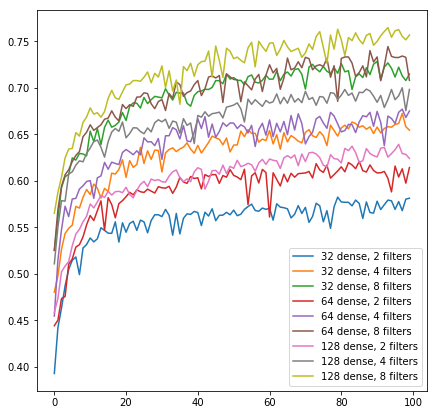

In [33]:
fig = plt.figure()
fig.set_size_inches([7, 7])
for hist in constant_histories:
    plt.plot(hist[1]['val_acc'], label='%d dense, %d filters'%hist[0])
plt.legend()
plt.show()

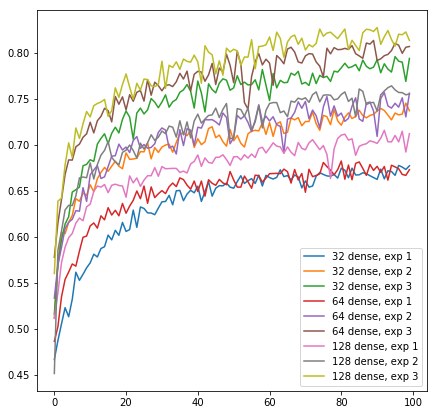

In [36]:
fig = plt.figure()
fig.set_size_inches([7, 7])
for hist in exp_histories:
    plt.plot(hist[1]['val_acc'], label='%d dense, exp %d'%hist[0])
plt.legend()
plt.show()